> ## US Drought & Meteorological Data Starter Notebook
This notebook will walk you trough loading the data and create a Dummy Classifier, showing a range of F1 scores that correspond to random predictions if given theclass priors.

## Loading & Visualizing the Data
In this section, we load the training and validation data into numpy arrays and visualize the drought classes and meteorological attributes.

We load the json files for training, validation and testing into the ``files`` dictionary.

In [18]:
import sys
!{sys.executable} -m pip install numpy pandas sktime sklearn scipy seaborn matplotlib

In [20]:
import numpy as np
import pandas as pd
import json
import os
from tqdm.auto import tqdm
from datetime import datetime
from scipy.interpolate import interp1d
from sklearn.preprocessing import RobustScaler

files = {}

for dirname, _, filenames in os.walk('.'):
    for filename in filenames:
        if 'train' in filename:
            files['train'] = os.path.join(dirname, filename)
        if 'valid' in filename:
            files['valid'] = os.path.join(dirname, filename)
        if 'test' in filename:
            files['test'] = os.path.join(dirname, filename)
            
print(files)

{'test': './test_timeseries.csv', 'train': './train_timeseries.csv', 'valid': './validation_timeseries.csv'}


The following classes exist, ranging from no drought (``None``), to extreme drought (``D4``).
This could be treated as a regression, ordinal or classification problem, but for now we will treat it as 5 distinct classes.

In [21]:
class2id = {
    'None': 0,
    'D0': 1,
    'D1': 2,
    'D2': 3,
    'D3': 4,
    'D4': 5,
}
id2class = {v: k for k, v in class2id.items()}

Now we'll define a helper method to load the datasets. This just walks through the json and discards the few samples that are corrupted.

In [22]:
dfs = {
    k: pd.read_csv(files[k]).set_index(['fips', 'date'])
    for k in files.keys()
}

We also add a helper function to interpolate the drought values.

In [23]:
def interpolate_nans(padata, pkind='linear'):
    """
    see: https://stackoverflow.com/a/53050216/2167159
    """
    aindexes = np.arange(padata.shape[0])
    agood_indexes, = np.where(np.isfinite(padata))
    f = interp1d(agood_indexes
               , padata[agood_indexes]
               , bounds_error=False
               , copy=False
               , fill_value="extrapolate"
               , kind=pkind)
    return f(aindexes)

We encode the day of year using sin/cos and add the data loading function `loadXY`.

In [27]:
def date_encode(date):
    if isinstance(date, str):
        date = datetime.strptime(date, "%Y-%m-%d")
    return (
        np.sin(2 * np.pi * date.timetuple().tm_yday / 366),
        np.cos(2 * np.pi * date.timetuple().tm_yday / 366),
    )

def loadXY(
    df,
    random_state=42, # keep this at 42
    window_size=180, # how many days in the past (default/competition: 180)
    target_size=6, # how many weeks into the future (default/competition: 6)
    fuse_past=True, # add the past drought observations? (default: True)
    return_fips=False, # return the county identifier (do not use for predictions)
    encode_season=True, # encode the season using the function above (default: True) 
    use_prev_year=False, # add observations from 1 year prior?
):
    df = dfs[df]
    soil_df = pd.read_csv("soil_data.csv")
    time_data_cols = sorted(
        [c for c in df.columns if c not in ["fips", "date", "score"]]
    )
    static_data_cols = sorted(
        [c for c in soil_df.columns if c not in ["soil", "lat", "lon"]]
    )
    count = 0
    score_df = df.dropna(subset=["score"])
    X_static = np.empty((len(df) // window_size, len(static_data_cols)))
    X_fips_date = []
    add_dim = 0
    if use_prev_year:
        add_dim += len(time_data_cols)
    if fuse_past:
        add_dim += 1
        if use_prev_year:
            add_dim += 1
    if encode_season:
        add_dim += 2
    X_time = np.empty(
        (len(df) // window_size, window_size, len(time_data_cols) + add_dim)
    )
    y_past = np.empty((len(df) // window_size, window_size))
    y_target = np.empty((len(df) // window_size, target_size))
    if random_state is not None:
        np.random.seed(random_state)
    for fips in tqdm(score_df.index.get_level_values(0).unique()):
        if random_state is not None:
            start_i = np.random.randint(1, window_size)
        else:
            start_i = 1
        fips_df = df[(df.index.get_level_values(0) == fips)]
        X = fips_df[time_data_cols].values
        y = fips_df["score"].values
        X_s = soil_df[soil_df["fips"] == fips][static_data_cols].values[0]
        for i in range(start_i, len(y) - (window_size + target_size * 7), window_size):
            X_fips_date.append((fips, fips_df.index[i : i + window_size][-1]))
            X_time[count, :, : len(time_data_cols)] = X[i : i + window_size]
            if use_prev_year:
                if i < 365 or len(X[i - 365 : i + window_size - 365]) < window_size:
                    continue
                X_time[count, :, -len(time_data_cols) :] = X[
                    i - 365 : i + window_size - 365
                ]
            if not fuse_past:
                y_past[count] = interpolate_nans(y[i : i + window_size])
            else:
                X_time[count, :, len(time_data_cols)] = interpolate_nans(
                    y[i : i + window_size]
                )
            if encode_season:
                enc_dates = [
                    date_encode(d) for f, d in fips_df.index[i : i + window_size].values
                ]
                d_sin, d_cos = [s for s, c in enc_dates], [c for s, c in enc_dates]
                X_time[count, :, len(time_data_cols) + (add_dim - 2)] = d_sin
                X_time[count, :, len(time_data_cols) + (add_dim - 2) + 1] = d_cos
            temp_y = y[i + window_size : i + window_size + target_size * 7]
            y_target[count] = np.array(temp_y[~np.isnan(temp_y)][:target_size])
            X_static[count] = X_s
            count += 1
    print(f"loaded {count} samples")
    results = [X_static[:count], X_time[:count], y_target[:count]]
    if not fuse_past:
        results.append(y_past[:count])
    if return_fips:
        results.append(X_fips_date)
    return results

Now we add a helper to normalise the data.

In [28]:
scaler_dict = {}
scaler_dict_static = {}
scaler_dict_past = {}


def normalize(X_static, X_time, y_past=None, fit=False):
    for index in tqdm(range(X_time.shape[-1])):
        if fit:
            scaler_dict[index] = RobustScaler().fit(X_time[:, :, index].reshape(-1, 1))
        X_time[:, :, index] = (
            scaler_dict[index]
            .transform(X_time[:, :, index].reshape(-1, 1))
            .reshape(-1, X_time.shape[-2])
        )
    for index in tqdm(range(X_static.shape[-1])):
        if fit:
            scaler_dict_static[index] = RobustScaler().fit(
                X_static[:, index].reshape(-1, 1)
            )
        X_static[:, index] = (
            scaler_dict_static[index]
            .transform(X_static[:, index].reshape(-1, 1))
            .reshape(1, -1)
        )
    index = 0
    if y_past is not None:
        if fit:
            scaler_dict_past[index] = RobustScaler().fit(y_past.reshape(-1, 1))
        y_past[:, :] = (
            scaler_dict_past[index]
            .transform(y_past.reshape(-1, 1))
            .reshape(-1, y_past.shape[-1])
        )
        return X_static, X_time, y_past
    return X_static, X_time

In [29]:
X_static_train, X_time_train, y_target_train = loadXY("train")
print("train shape", X_time_train.shape)
X_static_valid, X_time_valid, y_target_valid = loadXY("valid")
print("validation shape", X_time_valid.shape)
X_static_train, X_time_train = normalize(X_static_train, X_time_train, fit=True)
X_static_valid, X_time_valid = normalize(X_static_valid, X_time_valid)

  0%|          | 0/3108 [00:00<?, ?it/s]

loaded 103390 samples
train shape (103390, 180, 21)


  0%|          | 0/3108 [00:00<?, ?it/s]

loaded 8748 samples
validation shape (8748, 180, 21)


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

In [35]:
y_target_train[0]

array([4.7206, 5.    , 5.    , 5.    , 4.    , 4.    ])

Below we use PyTorch to load the data.

In [8]:
batch_size = 128
output_weeks = 6

In [9]:
import torch
from torch.utils.data import TensorDataset, DataLoader

train_data = TensorDataset(
    torch.tensor(X_time_train),
    torch.tensor(X_static_train),
    torch.tensor(y_target_train[:, :output_weeks]),
)
train_loader = DataLoader(
    train_data, shuffle=True, batch_size=batch_size, drop_last=False
)
valid_data = TensorDataset(
    torch.tensor(X_time_valid),
    torch.tensor(X_static_valid),
    torch.tensor(y_target_valid[:, :output_weeks]),
)
valid_loader = DataLoader(
    valid_data, shuffle=False, batch_size=batch_size, drop_last=False
)

Text(0.5, 1.0, 'Performance of ridge regression based on utilized days into the past')

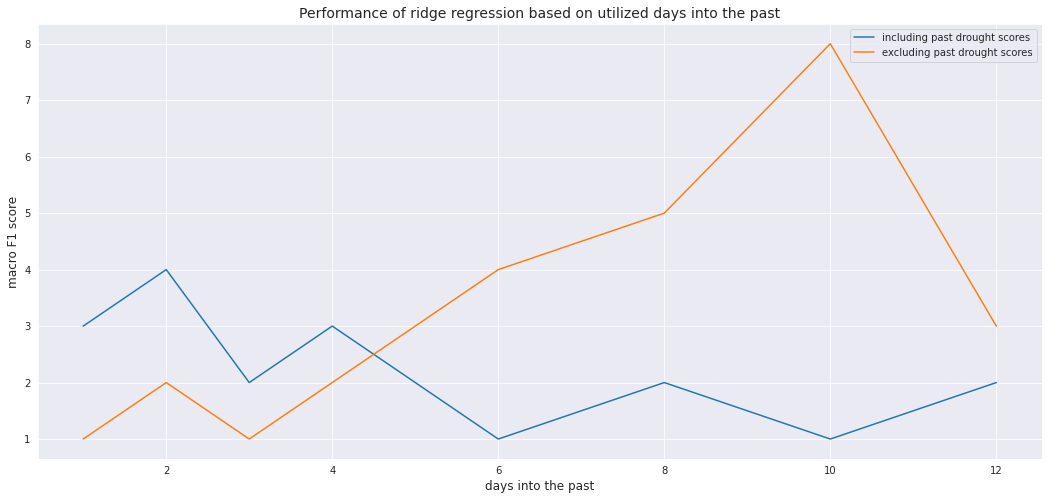

In [86]:
timesteps = [1,2,3,4,6,8,10,12]
timesteps_no_score = [1,2,3,4,6,8,10,12]
mf1s_per_timestep = [3,4,2,3,1,2,1,2]
mf1s_per_timestep_no_score = [1,2,1,2,4,5,8,3]
from matplotlib import pyplot as plt
import seaborn as sns


sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(18,8))
p = sns.lineplot(x = timesteps+timesteps_no_score, y = mf1s_per_timestep+mf1s_per_timestep_no_score, hue = ['including past drought scores']*len(timesteps)+['excluding past drought scores']*len(timesteps_no_score), ax=ax)
p.set_xlabel("days into the past", fontsize = 12)
p.set_ylabel("macro F1 score", fontsize = 12)
p.set_title("Performance of ridge regression based on utilized days into the past", fontsize=14)

In [65]:
index2feature = {
    0: 'PRECTOT',
    1: 'PS',
    2: 'QV2M',
    3: 'T2M',
    4: 'T2MDEW',
    5: 'T2MWET',
    6: 'T2M_MAX',
    7: 'T2M_MIN',
    8: 'T2M_RANGE',
    9: 'TS',
    10: 'WS10M',
    11: 'WS10M_MAX',
    12: 'WS10M_MIN',
    13: 'WS10M_RANGE',
    14: 'WS50M',
    15: 'WS50M_MAX',
    16: 'WS50M_MIN',
    17: 'WS50M_RANGE',
    18: 'SCORE',
    19: 'DATE_SIN',
    20: 'DATE_COS'
}
feature2index = {v: k for k, v in index2feature.items()}

[0.5, 0.5, 0.5, 0.2, 0.2, 0.2, 0.15, 0.15, 0.15, 0.11, 0.11, 0.11, 0.1, 0.1, 0.1, 0.05, 0.05, 0.05]
['WS50M_MAX', 'TS', 'T2M', 'WS50M_MIN', 'WS10M', 'T2MDEW', 'WS10M_RANGE', 'T2M_MIN', 'PS', 'WS50M', 'T2M_RANGE', 'QV2M', 'WS10M_MIN', 'T2M_MAX', 'PRECTOT', 'WS50M_RANGE', 'WS10M_MAX', 'T2MWET']


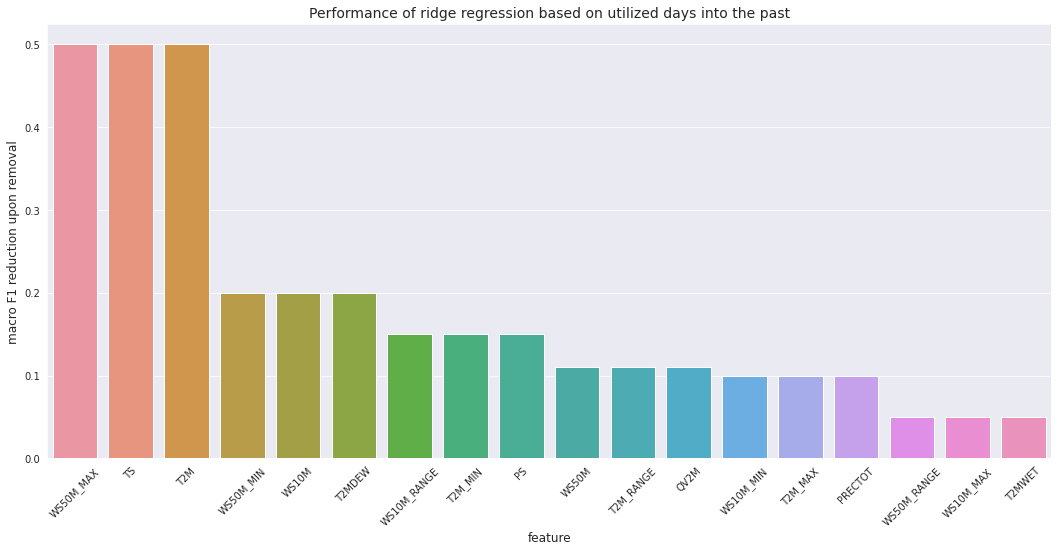

In [87]:
mf1s_per_feature = [0.1,0.15,0.11,0.5,0.2,0.05]*3

indices = list(range(len(mf1s_per_feature)))
feature_names = list(map(lambda x: index2feature[x], indices))
mf1s_per_feature, feature_names = zip(*sorted(zip(mf1s_per_feature, feature_names), reverse=True))
mf1s_per_feature = list(mf1s_per_feature)
feature_names = list(feature_names)
print(mf1s_per_feature)
print(feature_names)

sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(18,8))
p = sns.barplot(x = feature_names, y = mf1s_per_feature, ax=ax)
p.set_xlabel("feature", fontsize = 12)
p.set_ylabel("macro F1 reduction upon removal", fontsize = 12)
p.set_title("Performance of ridge regression based on utilized days into the past", fontsize=14)
ax.tick_params(axis='x', rotation=45)